# Happy-ness check of Twitter users
## Business case/User Problem
In today's world of social media keeping track to how people are perceiving and talking about your company, products and brand is increasingly important. TwHappy helps you keep track of that sentiment by monitoring Tweets that are pertinent to your interests and reporting back how positive or negative they are.

You provide the terms of interest, which can be your brand name, product name, company name or other, TwHappy lets you see all the relevant tweets and how positive or negative they are, together with a magnitude measure which gives an indication of how much emotion was actually in the tweet.

In [1]:
# some general imports
import os
import csv
from collections import namedtuple
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# quick limit of API usage, verbosity and results size while debugging/developing
DEBUG = False

## Google Cloud, Natural Language API - Sentiment analysis 
This is one of the APIs provided by Google Cloud. It takes a text string or document and puts it through powerful machine learning models to extract information about the language being used. Specifically the Sentiment analysis API allows you to understand the overall sentiment expressed in a block of text.

The results are calculated by sentence and then combined enabling the overall attitude (positive or negative) expressed within the text to be reported. Sentiment is represented by numerical score and magnitude values.

-  sentiment score indicates how positive or negative the text is.
-  sentiment magnitude indicates how much emotional content is present within the document.

A strongly negative or positive text will have extreme scores and large magnitudes, a neutral text will have a score close to 0 and a low magnitude value. A text that shows mixed emotions, ie some sentences that score very positively and others that score negatively will have a score near 0 and have a high magnitude score.

In [2]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

PATH = '/Users/alisonkline/Code'
# setting up authentication of the Google Cloud API
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = \
    PATH+'/TwHappy/res/tw-happy-1531935955393-fb5eb8b48a61.json'
#    '/Users/alisonkline/Code/TwHappy/res/tw-happy-d9fca2d70f33.json'

In [3]:
def print_result(annotations):
    """Presenting the Google sentiment results"""
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude

    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
        print('Sentence {} has a sentiment score of {}'.format(index, sentence_sentiment))

    print('Overall Sentiment: score of {:.2} with magnitude of {:.2}'.format(score, magnitude))
    return 0

In [4]:
def analyze(tw_texts):
    """Run a sentiment analysis request on a set of tweets."""
    client = language.LanguageServiceClient()
    sentiment = namedtuple("sentiment", ['score', 'magnitude'])
    sentiments = []
    
    print('Analysing sentiment for {} tweets...'.format(len(tw_texts)))
    for text in tw_texts:
        document = types.Document(content=text,type=enums.Document.Type.PLAIN_TEXT)
        annotations = client.analyze_sentiment(document=document)

        if DEBUG:
            print('\n{:40}'.format(text))
            print_result(annotations)
        sentiments.append(sentiment(annotations.document_sentiment.score, 
                             annotations.document_sentiment.magnitude))
    print('Done.')
    return sentiments

## Twitter
Twitter is an online news and social networking site where people communicate in short messages called tweets. Their API allows you to search for tweets that match a search term you provide. Structured data about the tweet is returned by the API, including when the tweet was made, the text of the tweet, who created the tweet, if it was in reply to another tweet and more.

I used an open-sourced helper library called Tweepy to interface with Twitter.

In [5]:
import tweepy

In [6]:
def get_twitter_api_obj(keys=None):
    """Creating Tweepy API object using default or provided keys."""
    if not keys:
        keys = pd.read_csv('res/Test-Twitter-Keys.csv')
    # Creating the authentication object
    auth = tweepy.OAuthHandler(keys.consumer_key[0], keys.consumer_secret[0])
    # Setting your access token and secret
    auth.set_access_token(keys.access_token[0], keys.access_token_secret[0])
    # Creating the API object while passing in auth information (notifications gives wait in secs)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)    
    return api

In [7]:
def get_tweets_from_search(api, query, language="en"):
    """Searching for tweets with provided query and with optional language selection."""
    # get 500 tweets from 5 pages as we get max 100 tweets per page
    
    (pages, count) = (1, 20) if DEBUG else (2, 100)
    max_pages = pages
    cursor = tweepy.Cursor(api.search, q=query, lang=language, count=count).pages(max_pages)

    tweets = []
    tw_texts = []
    for i, page in enumerate(cursor):
        now = datetime.now().strftime('%H:%M:%S')
        print('At {}: Obtained {} tweet pages for {!r}.'.format(now, str(i + 1), query))
        for tweet in page:
            tweets.append(tweet)

    print('Found {} tweets for {!r}.'.format(len(tweets), query))
    return tweets

# Presenting the results
Once I've collected and analyzed my data I present it to the user both graphically and by summarizing the tweets with the highest sentiment scores.

In [8]:
def plot_sent_vs_time(df):
    """Takes a DataFrame: index = created date, sentiment score, magnitude
    plots score against time, marker size = magnitude."""
    
    fig, (ax1,ax2) = plt.subplots(2,1, figsize = (20,12))

    ax1.scatter(df.index, df.score, c=df.score, s=(df.magnitude+0.1)*100, 
               cmap='RdYlGn', vmin=-1, vmax=1, label='Sentiment Score')
     
    # add spacing to x axis
    spread = (max(df.index)-min(df.index))
    
    padding = [(timedelta(minutes=30),pd.DateOffset(seconds=30),df.index.minute,'minute'),
               (timedelta(hours=5),pd.DateOffset(minutes=5),df.index.hour,'hour'),
               (timedelta(days=1),pd.DateOffset(minutes=15),df.index.hour,'hour'),
               (timedelta(days=7),pd.DateOffset(hours=1),df.index.day,'day'),
               (timedelta(days=14),pd.DateOffset(hours=4),df.index.day,'day'),
               (timedelta(weeks=4),pd.DateOffset(days=1),df.index.week,'week')]
    margin, group, lbl = next(((v[1], v[2], v[3]) for i,v in enumerate(padding) if v[0] > spread),
                         (pd.DateOffset(days=3),df.index.week,'week'))
    print('Spread is {}, so using margin {}'.format(spread, margin))
                         
    ax1.set_xlim([min(df.index)-margin, max(df.index)+margin])
    ax1.set_ylim([-1, 1])
    ax1.grid()

    # labeling
    ax1.legend(loc='upper right')
    ax1.set_xlabel("Tweet 'created at' time")
    ax1.set_ylabel('Tweet sentiment score')
    ax1.set_title('Sentiment Score for Tweets against time. Size of dot is \
                  magnitude, a measure of emotion in Tweet')
    
    boxprops = dict(color='gray', alpha=0.25)
    medianprops = dict(linewidth=1, linestyle='--')
    sns.boxplot(group, df.score, ax=ax2, showmeans=True, boxprops=boxprops, medianprops=medianprops)
    ax2.set_ylim([-1, 1])
    ax2.set_xlabel("Tweets agregated by {}".format(lbl))
    ax2.set_ylabel('Tweet sentiment score')
    ax2.set_title('Box plot statistics (Min, Max, Mean, Median, 25th and 75th %ile) \
                  of Sentiment Score showing trend over time')
    
    # formating x axis labels
    #fig.autofmt_xdate()   

    plt.show()

In [9]:
def swarm_and_hist(df):
    """Finds and prints the tweets with the highest sentiment scores."""
    df['score_str'] = round(df['score'],2)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,8))
    
    sns.swarmplot(x='score_str', y='magnitude', data=df, ax=ax1)

    ax1.set_xlabel("Sentiment Score")
    ax1.set_ylabel('Sentiment Magnitude')
    ax1.set_ylim([0, 1])
    ax1.set_title('Swamp plot of Tweet Sentiment against Tweet Magnitude.')
    
    ax2.hist(df.score, bins=15, alpha=0.5)
    ax2.set_xlim([-1, 1])
    ax2.legend(loc='upper right')
    ax2.set_title('Histogram of Tweet Sentiment.')
    plt.show()

In [10]:
def summarise_extreme_tweets(tweets, sentiments):
    """Finds and prints the tweets with the highest sentiment scores."""
    df = pd.DataFrame(sentiments)
    most_positive = df.loc[df.score == df.max()['score']]
    most_negative = df.loc[df.score == df.min()['score']]
    print('The most positive tweets:')
    for i in most_positive.index:
        summarise_tweet(tweets[i], sentiments[i].score, sentiments[i].magnitude)
    print('\n\nThe most negative tweets:')
    for i in most_negative.index:
        summarise_tweet(tweets[i], sentiments[i].score, sentiments[i].magnitude)

In [11]:
def summarise_tweet(t,s,m):
    """Prints a summary of a tweet and its sentiment."""
    if not t.in_reply_to_screen_name:
        print('\nAt {}, {}, (@{}) tweeted:'.format(
            t.created_at, t.user.name, t.user.screen_name, t.in_reply_to_screen_name))
    else:
        print('\nAt {}, {}, (@{}) tweeted in reply to {}:'.format(
            t.created_at, t.user.name, t.user.screen_name, t.in_reply_to_screen_name))
    text = (t.text[:98] + '..') if len(t.text) > 100 else t.text
    print('    {:.100}'.format(text))
    print('Sentiment score: {:.1f}, Magnitude: {:.1f}'.format(s,m))

# Putting it together
In order to calculate how Tw-Happy you should be, I take your input search term, use the Twitter API to find the latest tweets of interest to you, then run a Google Sentiment analysis on each of them in turn, before presenting the results graphically and summarizing the tweets with the highest sentiment scores.

In [12]:
def get_data(search_term):
    """Uses Twitter APIs to get tweets for provided search term. 
    Uses Google Sentiment API to analyse Tweet sentiment."""
    
    # authenticating a tweepy api object
    current_api = get_twitter_api_obj()
    # searching for tweets of interest
    tweets = get_tweets_from_search(current_api, search_term)
    
    #running Google sentiment analysis on found tweets
    tw_texts = [t.text if hasattr(t, 'text') else t.full_text for t in tweets]
    sentiments = analyze(tw_texts)
    return tweets, sentiments

In [13]:
def present(tweets, sentiments):
    """Summarizes key aspects of the data and presents it."""
    dfp = pd.DataFrame(sentiments)
    most_positive = dfp.loc[dfp.score == dfp.max()['score']]
    most_negative = dfp.loc[dfp.score == dfp.min()['score']]
    print('The most positive tweets have sentiment score of {:.2f} ({} tweets)'.format(
        dfp.max()['score'],len(most_positive)))
    print('The most negative tweets have sentiment score of {:.2f} ({} tweets)'.format(
        dfp.min()['score'],len(most_negative)))
    
    dfg = pd.DataFrame(sentiments)
    dfg['created_at'] = pd.DataFrame([t.created_at for t in tweets])
    dfg.set_index('created_at', inplace=True)
    plot_sent_vs_time(dfg)
    swarm_and_hist(dfg)

In [14]:
search_term = 'LiveRamp'

In [15]:
tweets, sentiments = get_data(search_term)

At 14:46:54: Obtained 1 tweet pages for 'LiveRamp'.
At 14:46:54: Obtained 2 tweet pages for 'LiveRamp'.
Found 200 tweets for 'LiveRamp'.
Analysing sentiment for 200 tweets...
Done.


The most positive tweets have sentiment score of 0.90 (10 tweets)
The most negative tweets have sentiment score of -0.70 (3 tweets)
Spread is 9 days 05:59:07, so using margin <DateOffset: hours=4>


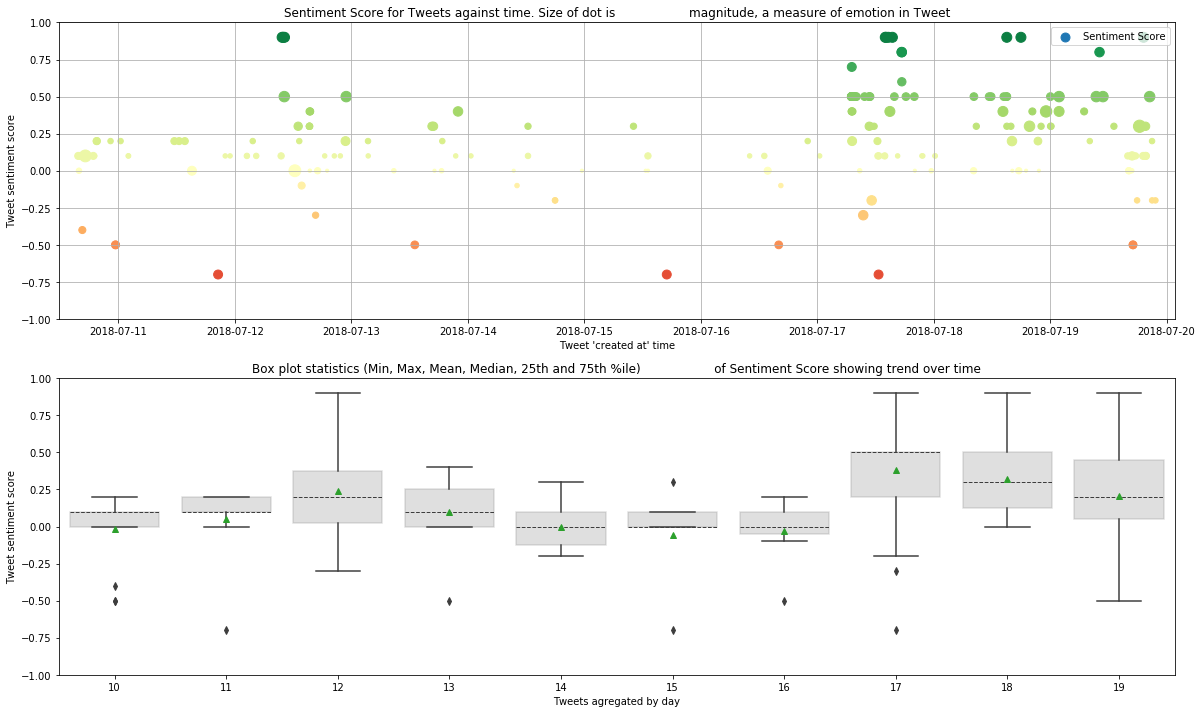

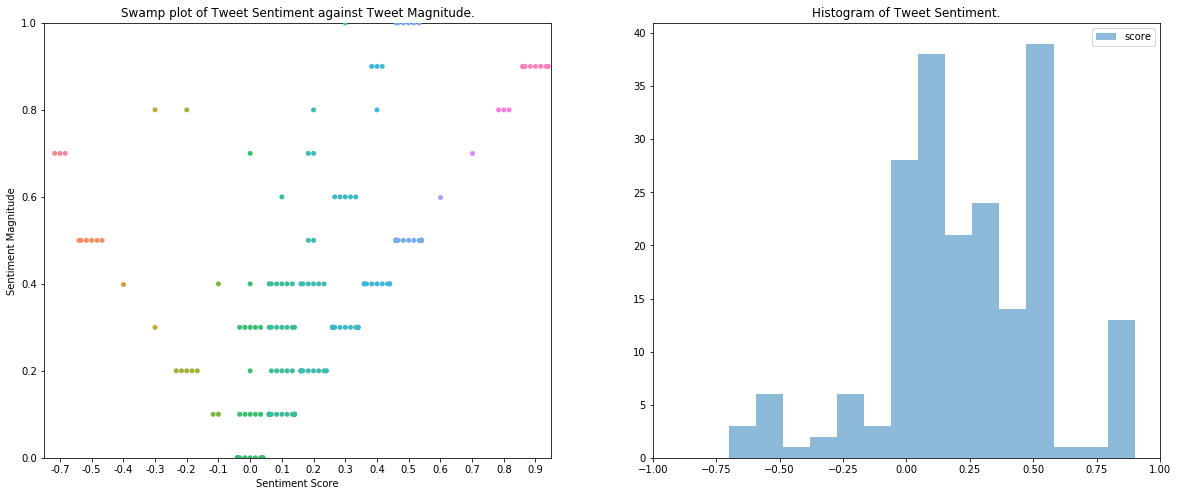

In [16]:
present(tweets, sentiments)

In [17]:
summarise_extreme_tweets(tweets, sentiments)

The most positive tweets:

At 2018-07-19 19:15:13, Sonobi, (@sonobi) tweeted:
    RT @MarTechSeries: @LiveRamp and @sonobi Collaboration Gives Marketers Unique Direct Access to Add..
Sentiment score: 0.9, Magnitude: 0.9

At 2018-07-18 17:58:35, Gillian Ca milleri, (@GMilleri) tweeted in reply to LiveRamp:
    @LiveRamp Excellent stuff
Sentiment score: 0.9, Magnitude: 0.9

At 2018-07-18 15:03:48, Boz Boschen, (@bozatwork) tweeted:
    LiveRamp and Sonobi Collaboration Gives Marketers Unique Direct Access to Addressable Consumers ht..
Sentiment score: 0.9, Magnitude: 0.9

At 2018-07-17 15:29:25, Andrew Cassin, (@Cassin75) tweeted:
    RT @sonobi: LiveRamp and Sonobi Collaboration Gives Marketers Unique Direct Access to Addressable ..
Sentiment score: 0.9, Magnitude: 0.9

At 2018-07-17 14:40:04, MediaVillage, (@MediaVillageCom) tweeted:
    RT @sonobi: LiveRamp and Sonobi Collaboration Gives Marketers Unique Direct Access to Addressable ..
Sentiment score: 0.9, Magnitude: 0.9

At 2018-07-

# Technical challenges

- Productizing not addressed in this prototype 
   - volume of API calls
   - size and structure of servers
   - latency and response time required at full production
- Twitter API limits - are these adequate or will we need a $$ level of relationship
- Re-tweets, and quote-tweets - how to handle and incorporate
- How can we improve the quality of the sentiment interpretation,
   - can we augment Googles api?
   - can we provide better insight by combining sentiment data differently?
   - what are the right trend lines to show allowing for the variation in tweet frequency?
   - can we provide better insight by treating Re-tweets and quoted tweets differently?
- Planning for much longer durations of data to allow historical analysis and more control on time windows

### Setup
- installing all required packages
    -  Juypter notebook
    -  Google cloud language sdk and packages
    -  Tweepy (for Twitter access)
- place provided api key files (two of them) into the 'res' folder and update the path variable in the first cell to match your setup